In [1]:
import pickle
import numpy as np
import pandas as pd
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
from time import time
import re
from sklearn.feature_extraction.text import CountVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

## Loading the data

In [2]:
from pymongo import MongoClient
import pandas as pd
# Connect to MongoDB database
client = MongoClient('mongodb://localhost:27017/')
db = client['CyberSe']

# Retrieve data from MongoDB collection
cyberbullying_data = list(db['cyberbullying'].find({}, {"_id": 0}))
cyberbullying = pd.DataFrame(cyberbullying_data)
# Close MongoDB connection
client.close()

In [3]:
df =cyberbullying
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

In [6]:
# map classes to labels
df['class'] = df['class'].map({0: 'hate speech', 1: 'offensive  language', 2: 'neither'})


### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text

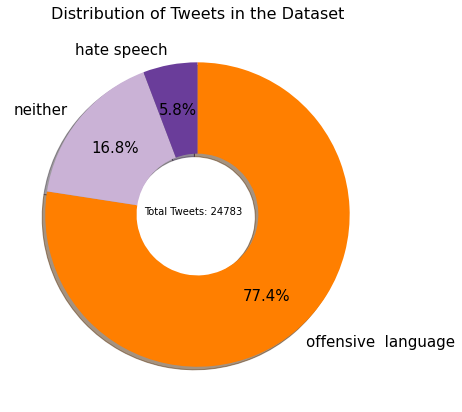

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (7,7))
sorted_counts = df['class'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [8]:
tweets=df.tweet

# Feature generation

In [9]:
import nltk
nltk.download('stopwords')
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\user\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
#Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [13]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [14]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [15]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [1]:
feats = get_feature_array(tweets)

NameError: name 'get_feature_array' is not defined

In [17]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)


In [18]:
M.shape

(24783, 4023)

In [19]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names



 # Running the model


### Implementing a training and predicting Pipeline

Separate training and testing data:

In [20]:
# map classes to labels
df['class'] = df['class'].map({ 'hate speech':0, 'offensive  language':1, 'neither':2})

In [21]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(M)
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))


Number of rows in the total set: 24783
Number of rows in the training set: 18587
Number of rows in the test set: 6196


Implement Pipeline:

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test,average='macro')

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train,average='macro')

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test,average='macro')

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train,average='macro')

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test,average='macro')

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train,average='macro')

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

Put Algorithms in Pipeline:

In [23]:
# make a list of models
models = [ DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(), 
          RandomForestClassifier(), BaggingClassifier(),
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]

In [24]:
re = pipeline(models,X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 24.42 sec
----------------------------------------------------
Training LinearSVC


C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training LinearSVC finished in 9.66 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 52.88 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 16.89 sec
----------------------------------------------------
Training BaggingClassifier
Training BaggingClassifier finished in 83.74 sec
----------------------------------------------------
Training LogisticRegression


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LogisticRegression finished in 7.27 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 36.87 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.09 sec
----------------------------------------------------


In [25]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

### Analyze the results of the Pipeline


In [26]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.829245,0.646777,0.637675,0.625174,0.170041,0.898693,0.818487,0.761196,0.763608,36.868405
1,LogisticRegression,0.851356,0.690050,0.595790,0.620915,0.183017,0.879324,0.777321,0.648586,0.683750,7.270235
2,BaggingClassifier,0.839090,0.647200,0.571580,0.589737,9.595035,0.991284,0.989898,0.975499,0.982574,83.740443
3,AdaBoostClassifier,0.832795,0.666983,0.563917,0.589363,9.368708,0.832679,0.651722,0.552500,0.575652,52.881862
4,DecisionTreeClassifier,0.791156,0.560768,0.556130,0.558108,0.220049,0.999785,0.999248,0.999824,0.999535,24.423449
5,LinearSVC,0.820045,0.631128,0.507225,0.542757,0.172023,0.890246,0.941807,0.639776,0.722375,9.656322
6,RandomForestClassifier,0.828922,0.682657,0.466422,0.494331,1.146213,0.999785,0.999535,0.999535,0.999535,16.892932
7,KNeighborsClassifier,0.775178,0.548740,0.362559,0.351485,15.928134,0.803034,0.772592,0.426892,0.457448,0.090505


In [27]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.775178,0.54874,0.362559,0.351485,0.170041,0.803034,0.651722,0.426892,0.457448,0.090505
max,0.851356,0.69005,0.637675,0.625174,15.928134,0.999785,0.999535,0.999824,0.999535,83.740443


In [28]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

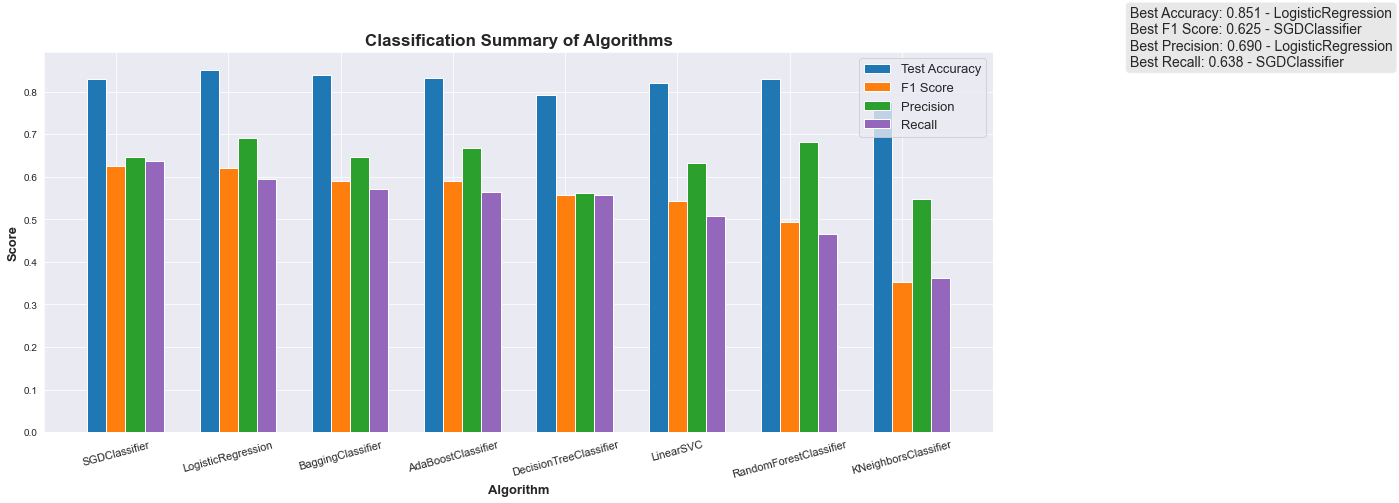

In [29]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [30]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

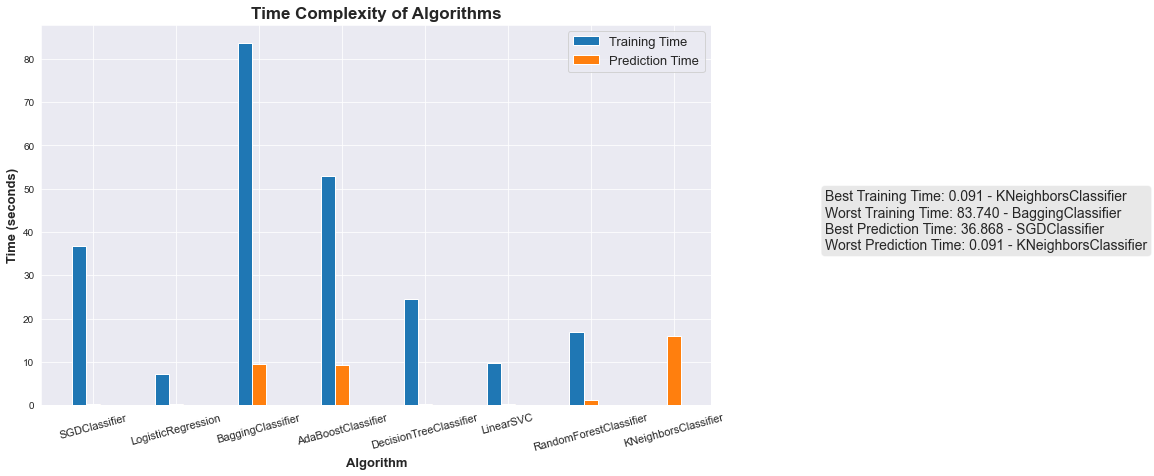

In [31]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

### Tuning Hyperparameters


In [32]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score,average='micro')

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions,average='macro')))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions,average='macro')))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions,average='macro')))

Stochastic Gradient Classifier:

In [33]:
# Dict for parameters

param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [200, 300, 400]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, X_train, y_train, X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.095, 'max_iter': 400}
Accuracy: 0.8313
F1-score: 0.5542
Precision: 0.6656
Recall: 0.5848


Logistic Regression Classifier:

In [34]:
# Dict for parameters
param_grid = {
    'C': [1, 1.2, 1.3, 1.4]
}

clf_lr = LogisticRegression()

param_tuning(clf_lr, param_grid, X_train, y_train, X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

LogisticRegression

Optimized Model
------
Best Parameters: {'C': 1.3}
Accuracy: 0.8475
F1-score: 0.6253
Precision: 0.6844
Recall: 0.5975


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree Classifier:

In [35]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, X_train, y_train, X_test, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 8, 'min_samples_split': 5}
Accuracy: 0.8155
F1-score: 0.5801
Precision: 0.6089
Recall: 0.5654


Random Forest Classifier:

In [36]:
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, X_train, y_train, X_test, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.8260
F1-score: 0.4961
Precision: 0.6762
Recall: 0.4675


Linear SVC:

In [37]:
param_grid = {    
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid,X_train, y_train, X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC

Optimized Model
------
Best Parameters: {'C': 1.2}
Accuracy: 0.8186
F1-score: 0.5969
Precision: 0.6142
Recall: 0.5829


C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Conclusion:
We found Logistic Regression to be the best suited model for our data. We achieved the following performance parameters:
                    
-	Accuracy: 84.75 %

### Final-Model

In [77]:
X1 = pd.DataFrame(M)
y1= df['class'].astype(int)

In [78]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=1.3,solver='liblinear'))
X_ = select.fit_transform(X1,y1)

In [79]:
model = LogisticRegression(class_weight='balanced',penalty='l2').fit(X_,y1)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
y_preds = model.predict(X_)

## Evaluating the results


In [90]:
from sklearn.metrics import classification_report
report = classification_report( y1, y_preds )
print(report)

              precision    recall  f1-score   support

           0       0.27      0.77      0.40      1430
           1       0.97      0.75      0.84     19190
           2       0.63      0.89      0.74      4163

    accuracy                           0.77     24783
   macro avg       0.62      0.80      0.66     24783
weighted avg       0.87      0.77      0.80     24783



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


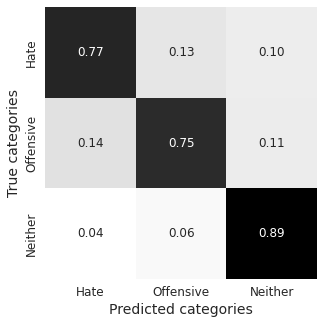

In [91]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel("True categories",fontsize=14)
plt.xlabel("Predicted categories",fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')